In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 Interior Points Method

### 1.1 Implementation of phi, grad and hess

In [2]:
def phi(x, t, Q, p, A, b):
    if np.any(b - A.dot(x) <= 0):
        return float("NaN")
    return t*(1/2 * (x.T).dot(Q).dot(x) + (p.T).dot(x)) - np.sum(np.log(b - A.dot(x)))

def grad(x, t, Q, p, A, b):
    d = 1. / (b - A.dot(x))
    return A.T.dot(d) + t * (Q.dot(x) + p)

def hess(x, t, Q, p, A, b):
    d = 1. / (b - A.dot(x))
    return A.T.dot(np.diag(d)**2).dot(A) + t * Q

### 1.2 Test

In [3]:
t = 1e1
Q = np.array([[6,0], [0, 4]])
p = np.array([2, -3])
A = np.array([[-4, 3], [-1, 2], [-2, 3], [-3, -2]])
b = np.array([2, 12, 7, 8])
x = np.array([3, 3])

print("phi: ", phi(x, t, Q, p, A, b))
print("grad: ", grad(x, t, Q, p, A, b))
print("hess: ", hess(x, t, Q, p, A, b))

phi:  411.671548933
grad:  [ 198.45845411   91.4852657 ]
hess:  [[ 60.91935891  -0.8683492 ]
 [ -0.8683492   40.97944415]]


## 2 Newton Methods

### 2.1 Damped Newton method

In [4]:
f = lambda x: phi(x, t, Q, p, A, b)
g = lambda x: grad(x, t, Q, p, A, b)
h = lambda x: hess(x, t, Q, p, A, b)

def dampedNewtonStep(x, f, g, h):
    H = h(x)
    J = g(x)
    d = np.linalg.inv(H).dot(J)
    l = J.dot(d)

    xnew = x - 1/(1 + np.sqrt(l))* d
    gap = 1/2 * l
    return xnew, gap

In [5]:
def dampedNewton(x0, f, g, h, tol, max_iter=40):
    xhist = []
    gaps = []
   
    gap = float("inf")
    i = 0
    
    while True and i < max_iter:
        x0, gap = dampedNewtonStep(x0, f, g, h)
        xhist.append(x0)
        gaps.append(gap)
        
        i += 1
        if gap < tol:
            break
    
    return x0, np.array(xhist), np.array(gaps)

x optimal:  [-0.07996617  0.46744074]


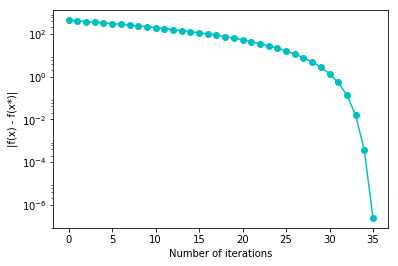

In [6]:
xstar_d, hi_d, gaps_damped = dampedNewton(x, f, g, h, 1e-6)
plt.yscale('log')
plt.plot(gaps_damped, 'co-')
plt.xlabel("Number of iterations")
plt.ylabel("|f(x) - f(x*)|")
print("x optimal: ", xstar_d)

### 2.2 Newton with backtracking line search

In [7]:
def linesearch(f, x, J, dx, alpha, beta):
    t = 1
    while (np.isnan(f(x + t * dx)) or (f(x + t * dx) > f(x) + alpha * t * J.dot(dx))) and t > 1e-3:
        t = beta * t
    return t

def newtonLS(x, f, g, h, tol, max_iter=40):
    xstar = None
    xhist = []
    gap = []
    
    i = 0
    
    while True and i < max_iter:
        H = h(x)
        J = g(x)
        dx = np.linalg.solve(H, -J)
        l = -J.dot(dx)
        
        # change to append x ?
        xhist.append(x)
        gap.append(l/2)
        
        if l < 2 * tol:
            break
        
        t = linesearch(f, x, J, dx, 0.5, 0.99)
        
        x = x + t * dx
        i += 1
    
    xstar = x
    
    return xstar, np.array(xhist), np.array(gap)

[-0.07996814  0.46744285]


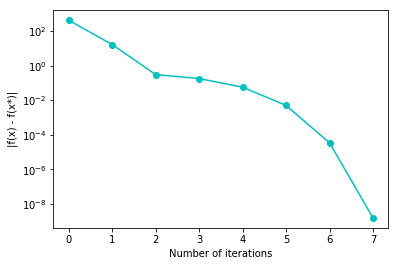

In [8]:
xstar_ls, xhist_ls, gaps_ls = newtonLS(x, f, g, h, 1e-6)
plt.yscale('log')
plt.xlabel("Number of iterations")
plt.ylabel("|f(x) - f(x*)|")
plt.plot(gaps_ls, 'co-')
print(xstar_ls)

## 3 Support Vector Machine Problem

### 3.1 Transform primal and dual to QP

In [9]:
def transform_svm_primal(tau, X, y):
    n, d = X.shape
    Y = np.diag(y)
    
    Q = np.zeros((d+n, d+n))
    Q[0:d, 0:d] = np.eye(d)
    
    p = 1 / (tau * n) * np.ones((d+n))
    p[0:d] = 0
    
    A = np.zeros((2*n, n+d))
    A[0:n,0:d] = - Y.dot(X)
    A[0:n, d:n+d] = - np.eye(n)
    A[n:2*n, d:n+d] = - np.eye(n)
    
    
    b = np.zeros((2*n))
    b[0:n] = -1
    
    return Q, p, A, b

def transform_svm_dual(tau, X, y):
    n, d = X.shape
    Y = np.diag(y)
    
    p = - np.ones((n))
    Q = Y.dot(X).dot(X.T.dot(Y))
    
    A = np.zeros((2*n, n))
    A[0:n, 0:n] = np.eye(n)
    A[n:2*n, 0:n] = - np.eye(n)
    
    b = np.zeros((2*n))
    b[0:n] = 1 / (tau * n)
    
    return Q, p, A, b

### 3.2 Implement Barrier method

In [10]:
def centeringStep(Q, p, A, b, x_0, t, tol, method='classic'):
    """
        use 'damped' to call damped Newton method,
        use 'classic' to call the usual Newton method with backtracking line search
    """
    f = lambda x_0: phi(x_0, t, Q, p, A, b)
    g = lambda x_0: grad(x_0, t, Q, p, A, b)
    h = lambda x_0: hess(x_0, t, Q, p, A, b)
    
    if method == 'damped':
        x_sol, xhist, gap = dampedNewton(x_0, f, g, h, tol)
    elif method == 'classic':
        x_sol, xhist, gap = newtonLS(x_0, f, g, h, tol)
    else:
        print("Incorrect method parameter: {}".format(method))
    
    return x_sol, xhist, gap

def barr_method(Q, p, A, b, x_0, mu=20, method='classic', tol=1e-6):
    """
        use 'damped' to call damped Newton method,
        use 'classic' to call the usual Newton method with backtracking line search
    """
    # m (nb of parameters) = nb of lines of A
    m = A.shape[0]
    
    # t needs to satisfies: t > 0
    t = 1
    
    gaps = []
    xhist = []
    x = x_0
    
    while m / t >= tol:
        # update
        x, hi, gap = centeringStep(Q, p, A, b, x, t, tol, method)
        
        # add point to historic
        xhist.append(x)
        gaps.append(gap)
        
        t = mu * t
    
    x_sol = xhist[-1]
    
    return x_sol, np.array(xhist), np.array(gaps)

### 3.3 Preprocess the Iris dataset

In [11]:
# load the iris dataset
data = pd.read_csv("iris.data", names=["sepal_l", "sepal_w", "petal_w", "petal_l", "class"])

# preprocess the datas
data = data.loc[data['class'].isin(['Iris-versicolor', 'Iris-virginica'])]
data['class'].replace(['Iris-versicolor', 'Iris-virginica'], [-1, 1], inplace=True)
X = data.values[:,:-1]
y = data.values[:, -1]

## Dual Problem

In [12]:
tau = 1e-3
Q, p, A, b = transform_svm_dual(tau, X, y)

n = X.shape[0]

# strictly feasible point
x_0 = 1 / (2 * tau * n) * np.ones((n))

xsol, xhist, gaps = barr_method(Q, p, A, b, x_0)


Q, p, A, b = transform_svm_primal(tau, X, y)
# strictly feasible point for primal problem
n, d = X.shape
x_0 = 2 * np.ones((n+d))
x_0[0:d] = 0

xsol, xhist, gaps = barr_method(Q, p, A, b, x_0)

## Primal Problem

In [13]:
X = data.values[:,:-1]
y = data.values[:, -1]

def split_train_test(X, y):
    # add offset
    offset = np.ones((len(X), 1))
    X = np.concatenate((X, offset), axis=1)

    # train on 80% of the data (select 80% of the data without replacement)
    index = np.random.choice(len(X), size=int(0.8*len(X)), replace=False)
    X_train = X[index]
    y_train = y[index]

    # recover the last 20% of unused data to test
    # y_true is the true labelling
    index_complement = [i for i in range(len(X)) if i not in index]
    X_test = X[index_complement]
    y_true = y[index_complement]
    
    return X_train, y_train, X_test, y_true

X_train, y_train, X_test, y_true = split_train_test(X, y)
tau = 1e-3
Q, p, A, b = transform_svm_primal(tau, X_train, y_train)

# strictly feasible point for primal problem
n, d = X_train.shape
x_0 = 2 * np.ones((n+d))
x_0[0:d] = 0

xsol, xhist, gaps = barr_method(Q, p, A, b, x_0)

## Accuracy on Iris Dataset

In [14]:
# y_pred is the class predicted by the SVM
y_pred = X_test.dot(xsol[0:d]) > 0
print("Accuracy: ", np.mean(y_pred == (y_true > 0)) * 100, "%")

Accuracy:  95.0 %


## Accuracy on Iris Dataset function of Tau

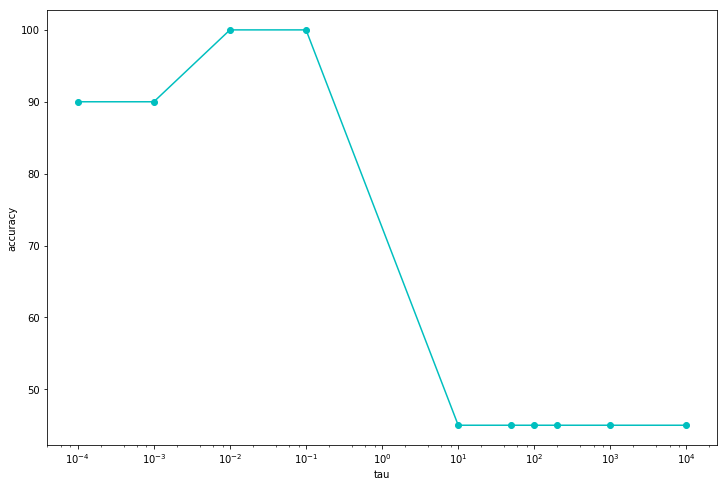

In [15]:
taus = [1e-4, 1e-3, 1e-2, 1e-1, 10, 50, 100, 200, 1e3, 1e4]
X = data.values[:,:-1]
y = data.values[:, -1]

X_train, y_train, X_test, y_true = split_train_test(X, y)

accuracies = []

for tau in taus:
    Q, p, A, b = transform_svm_primal(tau, X_train, y_train)
    
    # strictly feasible first point
    n, d = X_train.shape
    x_0 = 2 * np.ones((n+d))
    x_0[0:d] = 0

    xsol, xhist, gaps = barr_method(Q, p, A, b, x_0, 20)
    
    # append accuracy
    y_pred = X_test.dot(xsol[0:d]) > 0
    acc = np.mean(y_pred == (y_true > 0)) * 100
    accuracies.append(acc)

plt.figure(figsize=(12,8))
plt.xscale('log')
plt.xlabel("tau")
plt.ylabel("accuracy")
plt.plot(taus, accuracies, 'co-')

## Separating randomly generate data (Optional)

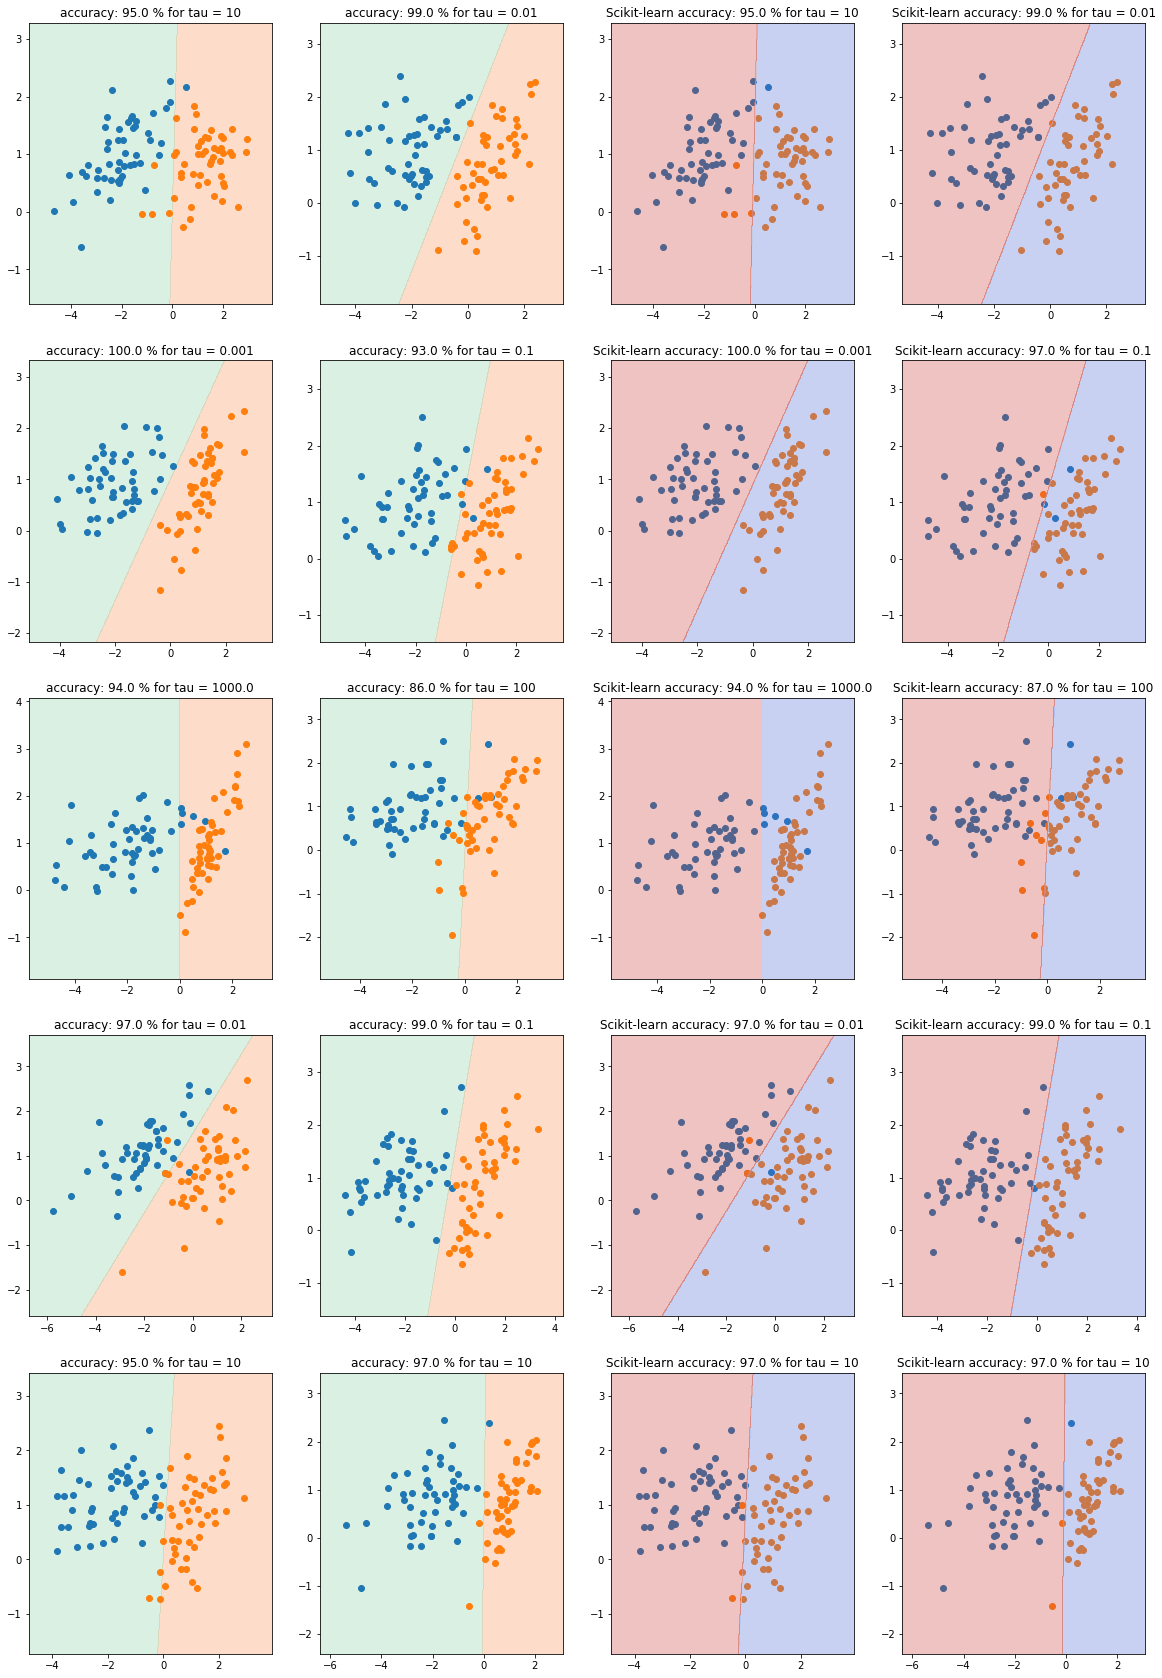

In [16]:
def random_classes(n):
    off = np.random.rand()
    t1 = np.random.multivariate_normal([-2,1], [[1.2+off/2, 0.3], [0.6,0.4]], n)
    t2 = np.random.multivariate_normal([1,0.8], [[1.2-off, 0.3], [0.6,0.4+off/2]], n)
    pos_label = np.ones(n)
    
    idx = np.random.choice(np.arange(2*n), 2*n, replace=False)
    
    X = np.concatenate((t1, t2))    
    y = np.concatenate((pos_label, -pos_label))
    return X[idx], y[idx]

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

import math
import random
from sklearn import svm
def test_random_data(pts, max_iter=10):
    taus =  [1e-3, 1e-2, 1e-1, 10, 100, 1e3]
    
    nby = int(max_iter/2) if max_iter % 2 == 0 else math.floor(max_iter/2)+1
    f, ax = plt.subplots(nby, 4, figsize=(20, nby*6))
    for i in range(max_iter):
        
        ix0, ix1 = math.floor(i/2), i % 2;
        
        X, y = random_classes(pts)
        
        # Add offset
        offset = np.ones((len(X), 1))
        X_off = np.concatenate((X, offset), axis=1)
        
        # randomly initialize tau
        tau = random.choice(taus)
        Q, p, A, b = transform_svm_primal(tau, X_off, y)

        # strictly feasible first point
        n, d = X_off.shape
        x_0 = 2 * np.ones((n+d))
        x_0[0:d] = 0

        xsol, xhist, gaps = barr_method(Q, p, A, b, x_0, 20, method='classic', tol=1e-9)
        
        #plot scikit learn
        ix00, ix11 = math.floor(i/2), (i % 2) + 2;
        clf = svm.LinearSVC(C=1/(n*tau))
        clf.fit(X, y)
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)
        ax[ix00, ix11].scatter(X[y == 1][:, 0], X[y == 1][:, 1])
        ax[ix00, ix11].scatter(X[y != 1][:, 0], X[y != 1][:, 1])
        plot_contours(ax[ix00, ix11], clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3)
        ax[ix00, ix11].set_title("Scikit-learn accuracy: {} % for tau = {}".format(clf.score(X, y)*100, tau))
        
        # compute accuracy
        w = xsol[0:d]
        y_pred = X_off.dot(w) > 0
        acc = np.mean(y_pred == (y > 0)) * 100

        # separate the data 
        Z = w[0]*xx + w[1]*yy + w[2]
        ax[ix0, ix1].contourf(xx, yy, Z, 0, cmap=plt.get_cmap('Spectral'), alpha=0.3)        
        ax[ix0, ix1].scatter(X[y == 1][:, 0], X[y == 1][:, 1])
        ax[ix0, ix1].scatter(X[y != 1][:, 0], X[y != 1][:, 1])
        ax[ix0, ix1].set_title("accuracy: {} % for tau = {}".format(acc, tau))
        
test_random_data(50)

## Duality gap versus Newton iterations

In [17]:
obj_fct = lambda x, Q: 1/2 * (x.T).dot(Q).dot(x) + (p.T).dot(x)

def obj_value(obj_fct, x_hist, Q):
    nb_iter = len(x_hist)
    fx_hist = np.zeros(nb_iter)
    
    for i in range(nb_iter):
        fx_hist[i] = obj_fct(x_hist[i],Q)
    
    return fx_hist

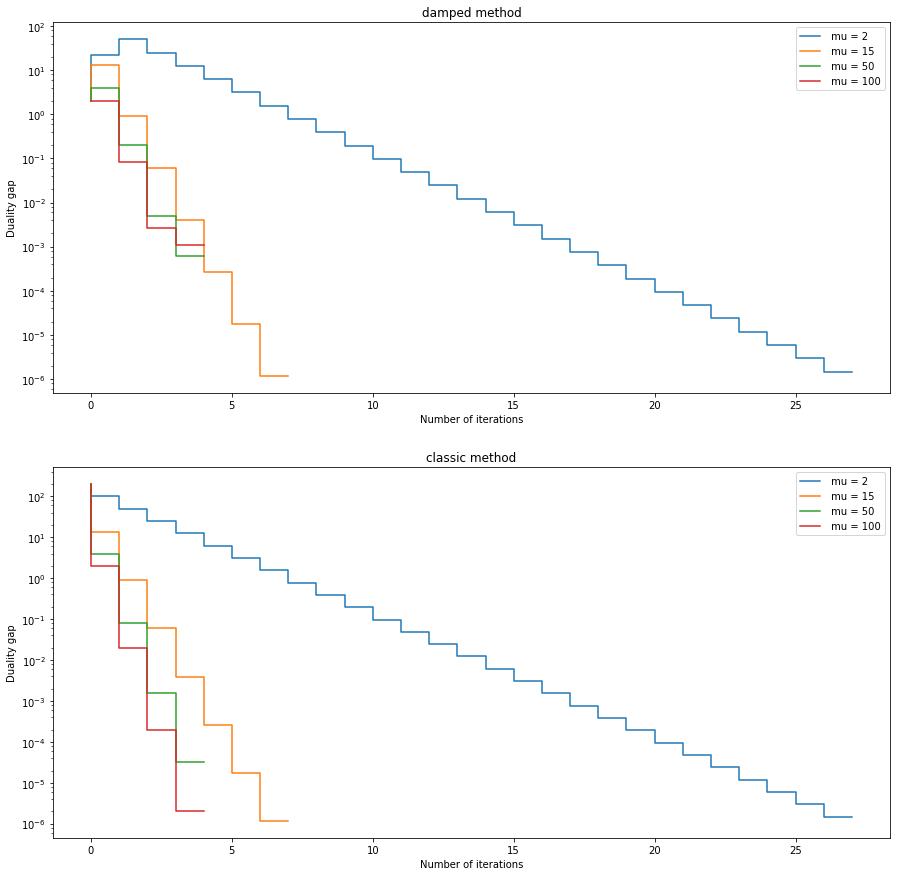

In [18]:
tau = 10
X = data.values[:,:-1]
y = data.values[:, -1]

# Add offset
#offset = np.ones((len(X), 1))
#X = np.concatenate((X, offset), axis=1)

n, d = X.shape

# starting strictly feasible pt for primal problem
x0_primal = 2 * np.ones((n+d))
x0_primal[0:d] = 0

# starting strictly feasible pt for dual problem
x0_dual = 1 / (2 * tau * n) * np.ones((n))


f, ax = plt.subplots(2, figsize=(15,15))

for i, method in enumerate(['damped', 'classic']):
    ax[i].set_yscale("log")
    ax[i].set_xlabel("Number of iterations")
    ax[i].set_ylabel("Duality gap")
    ax[i].set_title("{} method".format(method))
    
    for mu in [2, 15, 50, 100]:
        # primal historic
        Q, p, A, b = transform_svm_primal(tau, X, y)
        xsol_P, xhist_P, _ = barr_method(Q, p, A, b, x0_primal, mu, method)
        obj_value_P = obj_value(obj_fct, xhist_P, Q)

        # dual historic
        Q, p, A, b = transform_svm_dual(tau, X, y)
        xsol_D, xhist_D, _ = barr_method(Q, p, A, b, x0_dual, mu, method)
        obj_value_D = obj_value(obj_fct, xhist_D, Q)
        

        # compute duality gap
        dgap = obj_value_P + obj_value_D
        ax[i].step(np.arange(len(dgap)), dgap, label=" mu = {}".format(mu))

    ax[i].legend()